# Сравнительный анализ доходности тарифов "Смарт" и "Ультра"

## Общие положения

**Дата выполнения проекта:** 11 апреля 2021.

**Заказчик исследования:** коммерческий отдел оператора сотовой связи "Мегалайн".

**Цель исследования** — определить, доходность какова из тарифов — Smart или Ultra — выше.

**Задачи исследования:**
1. Проверить, отличается ли средняя выручка тарифа Smart от средней выручки тарифа Ultra.
2. Проверить, есть ли отличия между пользователями разных городов.
3. Сравнить полученные оценки и подготовить обоснованный вывод.

**Описание данных:** выборка данных по 500 пользователям тарифов "Смарт" и "Ультра" за 2018 год, предоставлена Заказчиком.

**Этапы исследования:**
1. Изучение данных.
2. Подготовка данных — удаление пропусков, дублей и аномалий.
3. Внутреннее обогащение данных.
4. Статистический и исследовательский анализ данных.
5. Общий вывод.

## Изучение данных

Для анализа предоставлены 5 файлов. Будем изучать каждый отдельно. Но первым шагом импортируем необходимые для работы библиотеки.

In [1]:
# импорт необходимых библиотек
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
# обновление библиотеки seaborn, при перезагрузке тетрадки перестает работать
# для работы графиков нужно выполнить эту ячейку, потом перезапустить ядро
# повторное выполнение ячейки не требуется, как я поняла, поэтому закомментировано

# !pip install -U seaborn

In [3]:
# зададим количество отображаемых столбцов, чтобы видеть все
pd.options.display.max_columns = 200

### Файл calls

**Описание файла:**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

In [4]:
# чтение файла из однозначно указанной директории
calls = pd.read_csv('calls.csv')

In [5]:
# запросим общую информацию о файле стандартным методом .info()
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


В файле нет пустых значений. Потребуется замена типа данных в столбце call_date. Перейдем к визуальному изучению данных, а также посмотрим, есть ли в файле дубли.

In [6]:
# напишем функцию, которая выводит первые 5 строк для визуального изучения
# а также подсчитывает количество и долю дублей в данных
def check(data):
    display(data.head())
    duplicates = data.duplicated().sum()
    duplicates_part = duplicates / len(data)
    print('Количество дублирующихся строк в данных:', duplicates)
    print('Доля дублей в данных: {:.2%}'.format(duplicates_part))

In [7]:
check(calls)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Количество дублирующихся строк в данных: 0
Доля дублей в данных: 0.00%


На первый взгляд данные выглядят удовлетворительно, полных дублей нет. Удостоверимся, что в данных нет неожиданных значений — например, отрицательного количества минут. Заодно посчитаем долю нулевых значений.

In [8]:
# напишем функцию, которая будет подсчитывать количество нулей и отрицательных значений
# в заданном столбце заданной таблицы
def zero_negative(data, col_name):
    zero_amount = data.query('{} == 0'.format(col_name))[col_name].count()    
    zero_part = zero_amount / len(data)
    negative_amount = data.query('{} < 0'.format(col_name))[col_name].count()
    negative_part = negative_amount / len(data)
    print('Количество нулей:', zero_amount)
    print('Доля нулей: {:.2%}'.format(zero_part))
    print('Количество отрицательных значений:', negative_amount)
    print('Доля отрицательных значений: {:.2%}'.format(negative_part))

In [9]:
# подсчитаем нули и пропуски для длительности звонка в файле calls
zero_negative(calls, 'duration')

Количество нулей: 39613
Доля нулей: 19.55%
Количество отрицательных значений: 0
Доля отрицательных значений: 0.00%


Практически пятая часть звонков продолжались 0 секунд. Либо звонки сбрасывали, либо есть какие-то нарушения в учете — требуется более детальное изучение. Посмотрим, по всем ли 500 пользователям есть данные в файле.

In [10]:
print('Количество уникальных user_id в файле:', len(calls['user_id'].unique()))

Количество уникальных user_id в файле: 492


В данных нет информации по звонкам 8 человек. Может быть, эти люди вообще не пользовались звонками (поскольку есть большой объем нулевых значений, значит, любые, даже несостоявшиеся звонки, фиксируются). Второй вариант — есть проблемы на стадии сбора данных. Прежде чем делать выводы, посмотрим, есть ли подобные отклонения в данных о смс и использовании интернета.

**Вывод:** в датасете нет полных дублей. Требуется изменение типа данных для call_date. В собранной статистике не хватает информации о 8 пользователях. В столбце duration (продолжительность) имеются нулевые значения. Подробно изучать нулевые значения будем на следующем этапе подготовки данных. 

### Файл internet

**Описание файла:**
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

In [11]:
# чтение файла из однозначно указанной директории
internet = pd.read_csv('internet.csv')

In [12]:
# запросим общую информацию о файле стандартным методом .info()
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Аналогично, нет пропусков и требуется замена типа данных в столбце session_date.
Изучим образец данных: сколько нулей, отрицательных значений и неактивных пользователей в датасете.

In [13]:
check(internet)
zero_negative(internet, 'mb_used')
print('Количество уникальных user_id в файле:', len(internet['user_id'].unique()))

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Количество дублирующихся строк в данных: 0
Доля дублей в данных: 0.00%
Количество нулей: 19598
Доля нулей: 13.12%
Количество отрицательных значений: 0
Доля отрицательных значений: 0.00%
Количество уникальных user_id в файле: 497


**Вывод:** также значительная доля нулей в использованных мегабайтах, неожиданных значений и дублей нет, по 3 абонентам нет записей. Вполне вероятно, что есть люди, которые не пользуются звонками или интернетом по тарифу — для обоснованного вывода необходимо изучить совокупные данные по всем услугам по всем пользователям, поэтому работу с нулями отложим до следующего шага.

### Файл messages

**Описание файла:**
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

In [14]:
# чтение файла из однозначно указанной директории
messages = pd.read_csv('messages.csv')

In [15]:
# запросим общую информацию о файле стандартным методом .info()
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [16]:
check(messages)
print('Количество уникальных user_id в файле:', len(messages['user_id'].unique()))

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Количество дублирующихся строк в данных: 0
Доля дублей в данных: 0.00%
Количество уникальных user_id в файле: 426


**Вывод:** файл messages нуждается только в преобразовании типа данных для столбца с датой. Пропущенных пользователей в этом файле значительно больше — 74 человека. В рассматриваемое время (2018 год) SMS как инструмент коммуникации продолжал активно замещаться мессанджерами, вероятно, какой-то процент людей к тому време действительно совсем прекратил им пользоваться.

### Файл tariffs

**Описание файла:**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [17]:
# чтение файла из однозначно указанной директории
tariffs = pd.read_csv('tariffs.csv')

In [18]:
# запросим общую информацию о файле стандартным методом .info()
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [19]:
check(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Количество дублирующихся строк в данных: 0
Доля дублей в данных: 0.00%


**Вывод:** все условия тарифа понятны. Данные могут быть использованы в сводной таблице, преобразования не требуются.

### Файл users

**Описание файла:**
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

In [20]:
# чтение файла из однозначно указанной директории
users = pd.read_csv('users.csv')

In [21]:
# запросим общую информацию о файле стандартным методом .info()
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [22]:
check(users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Количество дублирующихся строк в данных: 0
Доля дублей в данных: 0.00%


Проверим, по всем ли пользователям заполнен тариф.

In [23]:
users.groupby('tariff')['tariff'].count()

tariff
smart    351
ultra    149
Name: tariff, dtype: int64

**Вывод:** для каждого пользователя прописан тариф, на текущем этапе представляется, что прочие данные таблицы использоваться не будут. В целом, таблица не содержит дублей, а значения NaN только в столбце с датой прекращения пользования тарифом, что эквивалетно информации, что пользователь пользуется тарифом.

### Вывод

Предоставленные для анализа файлы содержат от 123036 до 202607 строк, что представляется достаточным для анализа объемом. В предоставленных данных нет дублей и отрицательных значений, наблюдается большой процент нулевых значений по минутам и гигабайтам, ситуация требует более внимательного изучения. На следующем этапе из дополнительных файлов — tariffs и users — в сводную таблицу будут добавлены тарифные планы для каждого user_id и выручка с каждого пользователя.

## Подготовка данных

На этапе подготовки данных сделаем сводную таблицу по звонкам, сообщениям и использованию интернета по пользователям и месяцам. Первым шагом выделим из даты месяц и округлим данные по израсходованным минутам и гигабайтам (по условиям тарифов, оператор всегда округляет значения вверх до целых).

### Добавление названия месяца, округление численных значений вверх

Поскольку идентичные преобразования потребуются для нескольких файлов, напишем функции для изменения формата даты, добавления названия месяца и округления значений вверх.

In [24]:
# напишем функцию, которая меняет формат даты и добавляет номер и название месяца
# для проверки после работы функции вернем первые 5 строчек датасета 
def add_month(data, col_name):
    data[col_name] = pd.to_datetime(data[col_name], format='%Y-%m-%d')
    data['month'] = data[col_name].dt.month
    data['month_name'] = data[col_name].dt.month_name(None)
    return data.head()

In [25]:
# напишем функцию, которая в заданном столбце заданного датасета округляет значения вверх
# и переводит их в целочисленный тип
def ceiling(data, col_name):
    data[col_name+'_up'] = np.ceil(data[col_name]).astype(int)
    return data.head()

In [26]:
# применим описанные выше функции к таблице calls
add_month(calls, 'call_date')
ceiling(calls, 'duration')

,id,call_date,duration,user_id,month,month_name,duration_up
0,1000_0,2018-07-25,0.00,1000,7,July,0
1,1000_1,2018-08-17,0.00,1000,8,August,0
2,1000_2,2018-06-11,2.85,1000,6,June,3
3,1000_3,2018-09-21,13.80,1000,9,September,14
4,1000_4,2018-12-15,5.18,1000,12,December,6


In [27]:
# и к таблице internet
add_month(internet, 'session_date')
ceiling(internet, 'mb_used')

,Unnamed: 0,id,mb_used,session_date,user_id,month,month_name,mb_used_up
0,0,1000_0,112.95,2018-11-25,1000,11,November,113
1,1,1000_1,1052.81,2018-09-07,1000,9,September,1053
2,2,1000_2,1197.26,2018-06-25,1000,6,June,1198
3,3,1000_3,550.27,2018-08-22,1000,8,August,551
4,4,1000_4,302.56,2018-09-24,1000,9,September,303


In [28]:
# добавим название месяца в таблицу messages
add_month(messages, 'message_date')

,id,message_date,user_id,month,month_name
0,1000_0,2018-06-27,1000,6,June
1,1000_1,2018-10-08,1000,10,October
2,1000_2,2018-08-04,1000,8,August
3,1000_3,2018-06-16,1000,6,June
4,1000_4,2018-12-05,1000,12,December


Все преобразования проши успешно. На следующем шаге объединим таблицы calls, internet и messages на основании совпадения столбцов user_id и month_name. В итоговую таблицу по каждому пользователю выведем сумму минут, гигабайт и смс по округленным вверх значениям.

### Создание сводной таблицы по расходу минут, мегабайт, sms

Как и в предыдущем случае, однотипные преобрзования потребуются несколько раз, поэтому подготовим функцию для посчета суммы значений по столбцам.

In [29]:
# напишем функцию, которая суммирует количество израсходованных минут/мегабайт
# с учетом пользователя и месяца и выводит сокращенную таблицу
def aggregation(data, col_name):
    data2 = data.groupby(['user_id', 'month', 'month_name'])\
    .agg({col_name: sum}).reset_index()
    return data2

In [30]:
# применим функцию к таблицам calls и internet
calls_agg = aggregation(calls, 'duration_up')
internet_agg = aggregation(internet, 'mb_used_up')

# объединим полученные таблицы
calls_internet = calls_agg.merge(internet_agg, how='outer', on = ['user_id', 'month', 'month_name'])
# изучим образец получившихся данных
calls_internet.query('user_id == 1001')

,user_id,month,month_name,duration_up,mb_used_up
8,1001,11,November,430.0,18452.0
9,1001,12,December,414.0,14053.0


In [31]:
# добавим информацию по количеству смс
messages_agg = messages.groupby(['user_id', 'month_name'])\
    .agg({'id': 'count'}).reset_index().rename(columns = {'id':'messages_amount'})

# объединим с таблицей по звонкам и интернету и выведем образец получившихся данных
calls_sms_inet = calls_internet.merge(messages_agg, how='outer', on = ['user_id', 'month_name'])
calls_sms_inet.query('user_id == 1002')

,user_id,month,month_name,duration_up,mb_used_up,messages_amount
10,1002,6,June,117.0,10871.0,4.0
11,1002,7,July,214.0,17601.0,11.0
12,1002,8,August,289.0,20347.0,13.0
13,1002,9,September,206.0,16712.0,4.0
14,1002,10,October,212.0,13905.0,10.0
15,1002,11,November,243.0,18610.0,16.0
16,1002,12,December,236.0,18137.0,12.0


Методы отработали корректно — получилась сводная таблица с количеством израсходованных минут, мегабайт и SMS по каждому user_id в разрезе месяцев. На этапе изучения данным мы фиксировали пропуски в user_id в каждой из таблиц: 8 в calls, 3 в intenet, 74 в messages. Посмотрим, какое количесто уникальных user_id в итоговой таблице.

In [32]:
print('Количество уникальных user_id в файле:', len(calls_sms_inet['user_id'].unique()))

Количество уникальных user_id в файле: 498


Группировка данных прошла с хорошим результатом — не хватает всего 2 пользователей. Вполне вероятно, что эти люди действительно не пользовались телефонами. То, что в итоговой таблице больше строк, чем в каждой из исходных, подтверждает догадку, что некоторые абоненты не пользуются определенными средствами: кто-то не звонит, кто-то не пользуется интернетом, а кто-то отказался от SMS. Таким образом, нулевые значения в каждом из столбцов не являются ошибками учета.

### Добавление данных по тарифным планам

Добавим в таблицу данные о тарифе и стоимости услуг для каждого пользователя.

In [33]:
# отберем из таблицы users данные по user_id и tariff
users_cut = users[['user_id', 'city', 'tariff']]

# добавим тариф в сводную таблицу звонков, смс и интернета
data_tariff = calls_sms_inet.merge(users_cut, on = 'user_id').rename(columns = {'tariff':'tariff_name'})
data_tariff.query('user_id == 1004')

,user_id,month,month_name,duration_up,mb_used_up,messages_amount,city,tariff_name
22,1004,5,May,35.0,13415.0,95.0,Новокузнецк,ultra
23,1004,6,June,171.0,17619.0,134.0,Новокузнецк,ultra
24,1004,7,July,135.0,22243.0,181.0,Новокузнецк,ultra
25,1004,8,August,137.0,28607.0,151.0,Новокузнецк,ultra
26,1004,9,September,117.0,15125.0,146.0,Новокузнецк,ultra
27,1004,10,October,145.0,18494.0,165.0,Новокузнецк,ultra
28,1004,11,November,117.0,15631.0,158.0,Новокузнецк,ultra
29,1004,12,December,130.0,18038.0,162.0,Новокузнецк,ultra


Добавим в таблицу данные по стоимости услуг по каждому тарифу.

In [34]:
# с помощью метода .merge() добавим данные из таблицы tariffs
# посмотрим, как прошло объединение
data = data_tariff.merge(tariffs, on = 'tariff_name')
data.tail(10)

,user_id,month,month_name,duration_up,mb_used_up,messages_amount,city,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
3204,1498,10,October,247.0,20604.0,42.0,Владикавказ,smart,50,15360,500,550,200,3,3
3205,1499,9,September,70.0,1848.0,11.0,Пермь,smart,50,15360,500,550,200,3,3
3206,1499,10,October,449.0,17809.0,48.0,Пермь,smart,50,15360,500,550,200,3,3
3207,1499,11,November,612.0,17984.0,59.0,Пермь,smart,50,15360,500,550,200,3,3
3208,1499,12,December,492.0,13077.0,66.0,Пермь,smart,50,15360,500,550,200,3,3
3209,1489,8,August,NaN,11066.0,17.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3
3210,1489,9,September,NaN,17232.0,32.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3
3211,1489,10,October,NaN,19588.0,21.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3
3212,1489,11,November,NaN,17516.0,20.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3
3213,1489,12,December,NaN,17341.0,35.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3


Вся исходная информация собрана, на следующем этапе проведем необходимые вычисления, чтобы определить доходность по тарифам.

### Расчет выручки с каждого пользователя

Посчитаем, какую сумму приносит каждый абонент. Для этого вычислим стоимость услуг, которые пользователи оплачивают сверх тарифа. Первым шагом заменим значения NaN на нулевые — пустые значения появились в результате объединения таблиц (в каждой таблице были недостающие значения в user_id, которые впоследствии стали пустыми значениями в сводной таблице), поэтому замена на 0 не поменяет сути данных. 

Также высчитаем количество гигабайт, которые пользователи используют сверх тарифа — тарифные планы включают в себя определенное количество Мб, учет трафика идет также по Мб, а вот оплачивается дополнительный трафик по Гб. Округлим количество полученных Гб вверх до целых, согласно базовой логике работы тарифов. Один Гб содержит 1024 Мб.

In [35]:
# заполним NaN нулями с помощью метода .fillna()
data = data.fillna(0)

# найдем разницу между использованным трафиком и объемом Мб, включенных в тариф
# переведем в Гб и сделаем целочисленным значением
data['gb_extra_used'] = np.ceil((data['mb_used_up'] - data['mb_per_month_included']) / 1024).astype(int)

# посмотрим, что получилось
data[['user_id', 'month_name', 'tariff_name', 'mb_used_up', 'mb_per_month_included', 'gb_extra_used']].tail()

,user_id,month_name,tariff_name,mb_used_up,mb_per_month_included,gb_extra_used
3209,1489,August,smart,11066.0,15360,-4
3210,1489,September,smart,17232.0,15360,2
3211,1489,October,smart,19588.0,15360,5
3212,1489,November,smart,17516.0,15360,3
3213,1489,December,smart,17341.0,15360,2


Добавим столбцы с расчетом дохода по видам услуг — минуты, интернет, sms — использованных сверх тарифа. Как видим по таблице выше, если абонент не вышел за объем услуг, предусмотренных тарифом, то получается отрицательно значение. Для дальнейшего корректного анализа заменим отрицательные значения в новых столбцах на нулевые — если абонент уложился в тариф, то дополнительного дохода не было.

In [36]:
# добавим столбцы по видам услуг
data['revenue_calls'] = (data['duration_up'] - data['minutes_included']) * data['rub_per_minute']
data['revenue_internet'] = data['gb_extra_used'] * data['rub_per_gb']
data['revenue_sms'] = (data['messages_amount'] - data['messages_included']) * data['rub_per_message']

In [37]:
# напишем функцию, которая заменит отрицательные значения на нулевые
def excluding_subzero(col_name):
    data[col_name] = data.apply(lambda row: 0 if row[col_name] < 0 else row[col_name], axis=1)

In [38]:
# заменим отрицательные значения на нулевые
excluding_subzero('revenue_calls')
excluding_subzero('revenue_internet')
excluding_subzero('revenue_sms')

# проверим результат работы функции
data[['user_id', 'month_name', 'tariff_name', 'revenue_calls', 'revenue_internet', 'revenue_sms']].tail()

,user_id,month_name,tariff_name,revenue_calls,revenue_internet,revenue_sms
3209,1489,August,smart,0.0,0,0.0
3210,1489,September,smart,0.0,400,0.0
3211,1489,October,smart,0.0,1000,0.0
3212,1489,November,smart,0.0,600,0.0
3213,1489,December,smart,0.0,400,0.0


Отрицательные значения успешно заменены. Добавим еще один столбец со сводным доходом по каждому пользователю по месяцам: сложим доходы по видам услуг с оплатой по тарифу.

In [39]:
# сложим дополнительный доход по видам услуг и оплату по тарифу
data['revenue'] = data['revenue_calls'] + data['revenue_internet'] \
                + data['revenue_sms'] + data['rub_monthly_fee']

# посмотрим, что получилось
data[['user_id', 'month_name', 'tariff_name', 'rub_monthly_fee',\
      'revenue_calls', 'revenue_internet', 'revenue_sms', 'revenue']].query('user_id == 1005')

,user_id,month_name,tariff_name,rub_monthly_fee,revenue_calls,revenue_internet,revenue_sms,revenue
994,1005,January,smart,550,0.0,0,0.0,550.0
995,1005,February,smart,550,0.0,0,0.0,550.0
996,1005,March,smart,550,318.0,0,18.0,886.0
997,1005,April,smart,550,636.0,0,0.0,1186.0
998,1005,May,smart,550,285.0,0,0.0,835.0
999,1005,June,smart,550,336.0,0,0.0,886.0
1000,1005,July,smart,550,207.0,0,18.0,775.0
1001,1005,August,smart,550,357.0,0,42.0,949.0
1002,1005,September,smart,550,0.0,0,6.0,556.0
1003,1005,October,smart,550,669.0,0,0.0,1219.0


Мы получили удобную для анализа сводную таблицу данных по каждому абоненту по каждому месяцу. Перейдем к более детальному изучению тарифов.

### Вывод

В итоговом файле остались записи по 498 абонентам, подтвердилась догадка, что нулевые значения по виду услуг не являются ошибками учета (каждый пользователь выбирает наиболее подходящие форматы общения, часть пользователей, вероятно, могут пользоваться только одним видом связи). Отрицательные значения, появившиеся в ходе преобразований, заменены на нулевые. Данные готовы к анализу.

## Статистический и исследовательский анализ данных

В ходе анализа проверим гипотезу, что доходность тарифов Smart и Ultra одинаковая. Но для начала изучим характеристики положения данных.

### Общая информация о поведении абонентов разных тарифов

Изучим общую информацию о пользователях тарифов Smart и Ultra.

In [40]:
smart_check = data.query('tariff_name == "smart"')
ultra_check = data.query('tariff_name == "ultra"')

print('Количество уникальных пользователей тарифа Smart:', len(smart_check['user_id'].unique()))
smart_check[['revenue', 'minutes_included', 'duration_up', 'mb_per_month_included',\
       'mb_used_up', 'messages_included', 'messages_amount']].describe().astype(int)

Количество уникальных пользователей тарифа Smart: 350


,revenue,minutes_included,duration_up,mb_per_month_included,mb_used_up,messages_included,messages_amount
count,2229,2229,2229,2229,2229,2229,2229
mean,1294,500,417,15360,16229,50,33
std,820,0,190,0,5877,0,28
min,550,500,0,15360,0,50,0
25%,550,500,282,15360,12658,50,10
50%,1038,500,422,15360,16531,50,28
75%,1750,500,545,15360,20068,50,51
max,6770,500,1435,15360,38610,50,143


In [41]:
print('Количество уникальных пользователей тарифа Ultra:', len(ultra_check['user_id'].unique()))
ultra_check[['revenue', 'minutes_included', 'duration_up', 'mb_per_month_included',\
       'mb_used_up', 'messages_included', 'messages_amount']].describe().astype(int)

Количество уникальных пользователей тарифа Ultra: 148


,revenue,minutes_included,duration_up,mb_per_month_included,mb_used_up,messages_included,messages_amount
count,985,985,985,985,985,985,985
mean,2071,3000,526,30720,19486,1000,49
std,378,0,317,0,10096,0,47
min,1950,3000,0,30720,0,1000,0
25%,1950,3000,284,30720,11785,1000,6
50%,1950,3000,518,30720,19324,1000,38
75%,1950,3000,752,30720,26863,1000,79
max,4800,3000,1673,30720,49789,1000,224


В выборку попали две трети абонентов тарифа Smart. Средний доход с абонента на этом тарифе — 1294 р. 
Абонентов тарифа Ultra в выборке всего 148 человек (чуть менее 30%) со средней доходностью 2071 р.
Стандратные отклонения доходности выборок значительно отличаются: 820 у Smart против 378 у Ultra.

В среднем абоненты тарифа Smart не успевают потратить минуты и SMS, а вот интернет им приходится докупать (среднее 16300 Мб против 15360 включенных в пакет). Абоненты тарифа Ultra в среднем с большим запасом укладываются в отведенные тарифом рамки (75% значений по каждому виду услуг меньше, чем установленные тарифом лимиты).

### Распределение изучаемых характеристик

Изучим сравнительное распределение данных выборки по видам услуг: посмотрим на графике, как отличаются распределения минут, мегабайт и SMS в каждом из тарифов.

In [42]:
# для оптимизации работы напишем фукнцию, которая строит графики и делает подписи
# в качестве аргументов функция принимает колонку, по которой надо построить график, 
# название графика и подписи осей

# при перезагрузке тетрадки теряется обновление библиотеки, сделала отдельную ячейку, которая подгружает обновление, 
# но после этого требуется рестарт и вроде как повторно ее не надо запускать, поэтому закомментирована

def hist_captions (col, title, x):
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    sns.histplot(data=data[['user_id', col, 'tariff_name']], x=col, kde=True, hue='tariff_name')
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel('Количество наблюдений')
    plt.show

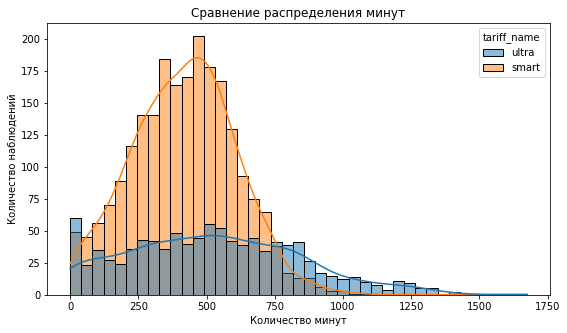

In [43]:
# построим график для звонков
hist_captions('duration_up', 'Сравнение распределения минут', 'Количество минут')

Распределение использования минут на тарифе Ultra более равномерное. Количество наблюдений меньше, но и пользователей меньше почти в 2,5 раза.

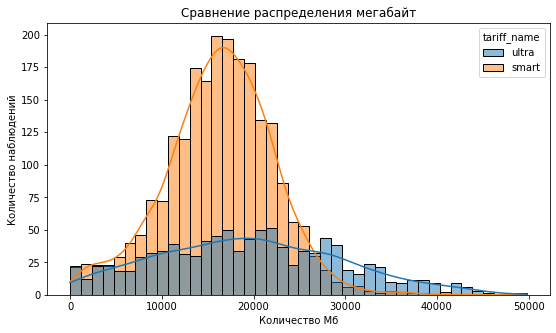

In [44]:
# построим график для использования интернета
hist_captions('mb_used_up', 'Сравнение распределения мегабайт', 'Количество Мб')

Аналогичная картина и в использовании интернета: пользователи Ultra очень равномерно распределены между трафиком до 5 Гб и более 25 Гб, тогда как у пользователей Smart если ярко выраженное "ядро" пользователей в диапазоне от 15 до 20 Гб.

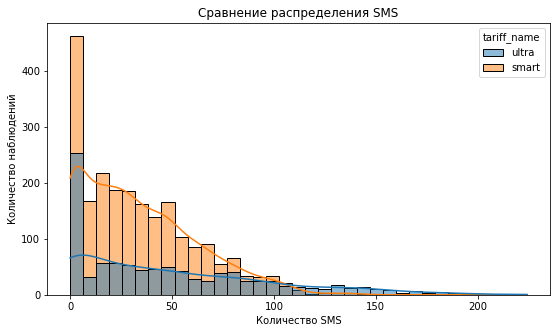

In [45]:
# построим график для сообщений
hist_captions('messages_amount', 'Сравнение распределения SMS', 'Количество SMS')

Большая часть абонентов обоих тарифов практически не пользуется SMS. Большинство пользователей за наблюдаемый период отправили до 75 сообщений. Как и в предыдущих случаях график в тарифе Ultra более пологий.

Характер распределений использования услуг на тарифах Smart и Ultra сильно отличается.

### Статистические показатели изучаемых характеристик

Посмотрим, как соотносятся друг с другом статистические метрики по тарифам. Создадим сводную таблицу по месяцам по тарифам со средним, дисперсией и средним стандартным отклонением.

In [46]:
# воспользуемся функцией, чтобы в сводной таблице применить расчет дисперсии и отклонения для выборки, 
# а не для генеральной совокупности, как по умолчанию
def new_std(x):
    return np.std(x, ddof=1)
def new_var(x):
    return np.var(x, ddof=1)

# создадим сводную таблицу, значения округлим до целых
data_pivot = data.pivot_table(index = ['tariff_name', 'month'], values = ['duration_up', 'mb_used_up', 'messages_amount'],\
                                                  aggfunc = ['mean', new_var, new_std]).astype(int)
data_pivot.head()

mean                                new_var  \
                  duration_up mb_used_up messages_amount duration_up   
tariff_name month                                                      
smart       1             203       8524              18       23787   
            2             298      11611              24       36412   
            3             390      15123              31       36823   
            4             367      13479              30       34778   
            5             387      15825              33       34820   

                                                 new_std             \
                  mb_used_up messages_amount duration_up mb_used_up   
tariff_name month                                                     
smart       1       41626212             262         154       6451   
            2       39119349             473         190       6254   
            3       34052595             718         191       5835   
            4       32547357             602         186       5705   
            5       35822355             730         186       5985   

                                   
                  messages_amount  
tariff_name month                  
smart       1                  16  
            2                  21  
            3                  26  
            4                  24  
            5                  27

In [47]:
# сделаем из сводной таблицы два набора данных для построения графиков
smart = data_pivot.query('tariff_name == "smart"')
ultra = data_pivot.query('tariff_name == "ultra"')

In [48]:
# напишем функцию, которая строит графики на основании данных таблиц smart и ultra
# помимо графиков зададим константу - объем услуг, включенных в тариф Smart
def bar_maker(ind1, ind2, const, t, y_l):
    x = np.arange(1, len(smart.index) + 1)
    smart_bar = smart[(ind1, ind2)]
    ultra_bar = ultra[(ind1, ind2)]
    width = 0.35
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    rects1 = ax.bar(x - width/2, smart_bar, width, label='Smart', color='#ed984e', alpha = 0.75)
    rects2 = ax.bar(x + width/2, ultra_bar, width, label='Ultra', color='#3285a8', alpha = 0.75) 
    ax.hlines([const], 0, 1, transform=ax.get_yaxis_transform(), colors='orange')
    ax.set_ylabel(y_l)
    ax.set_title(t)
    ax.set_xticks(x)
    ax.set_xticklabels(['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'])
    fig.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0., loc='upper left')
    fig.tight_layout()
    plt.show()

Изучим изменение рассматриваемых характеристик на графиках.

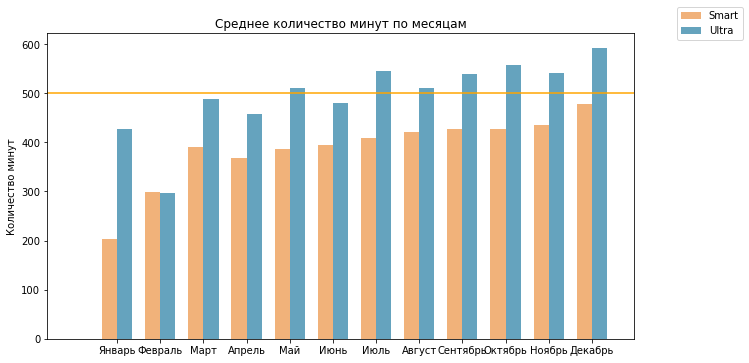

In [49]:
# построим график среднего времени разговоров для каждого тарифа в разрезе месяцев
bar_maker('mean', 'duration_up', 500, 'Среднее количество минут по месяцам', 'Количество минут')

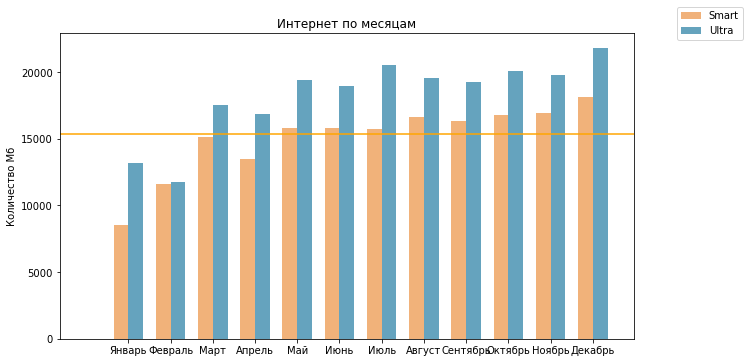

In [50]:
# построим график среднего пользования интернетом для каждого тарифа в разрезе месяцев
bar_maker('mean', 'mb_used_up', 15360, 'Интернет по месяцам', 'Количество Мб')

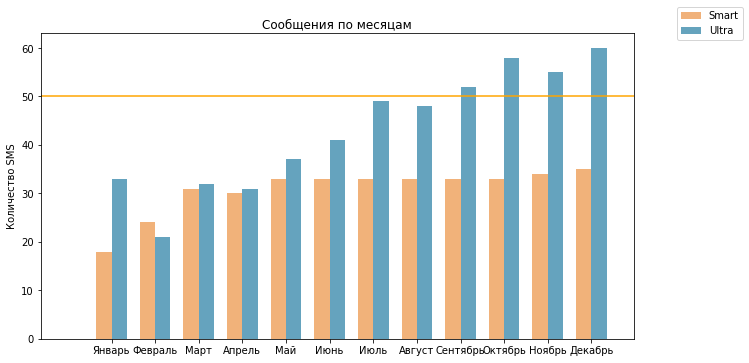

In [51]:
# построим график использования смс для каждого тарифа в разрезе месяцев
bar_maker('mean', 'messages_amount', 50, 'Сообщения по месяцам', 'Количество SMS')

Абоненты тарифа Ultra в среднем пользуются бОльшим количеством минут, мегабайт и SMS. Но разница не столь существенная — в тарифный лимит у Ultra включено в 6 раз больше минут, в 2 раза больше трафика и в 20 раз больше SMS. По факту, пользователи Ultra в среднем лишь незначительно превышают лимиты, установленные для тарифа Smart. По обоим тарифам по всем видам услуг наблюдается заметный спад в январе-феврале. Во второй половине года пользователи тарифа Smart в среднем не укладывались в лимиты по интернету.

Построим аналогичные графики для дисперсии. Константу установим на уровне 0.

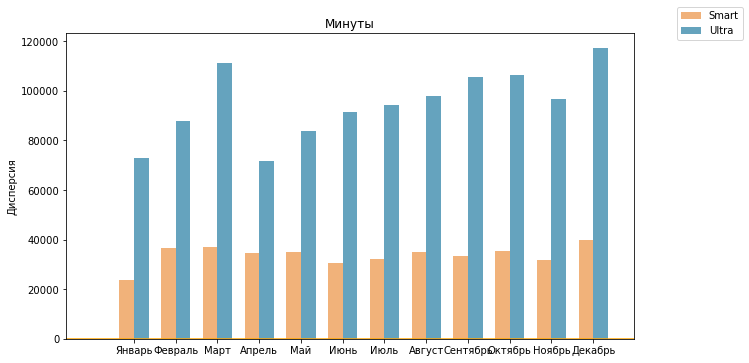

In [52]:
# график дисперсии минут для каждого тарифа в разрезе месяцев
bar_maker('new_var', 'duration_up', 0, 'Минуты', 'Дисперсия')

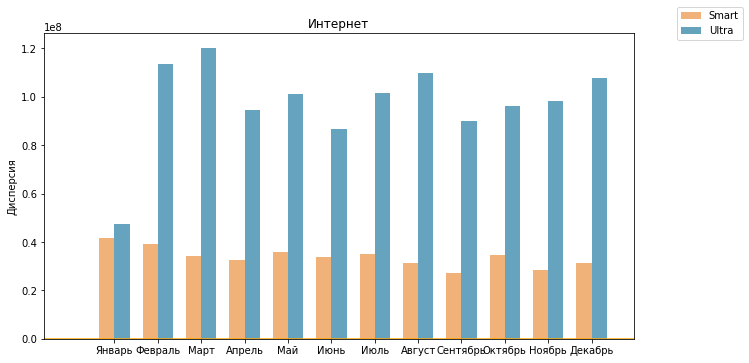

In [53]:
# график дисперсии интернета для каждого тарифа в разрезе месяцев
bar_maker('new_var', 'mb_used_up', 0, 'Интернет', 'Дисперсия')

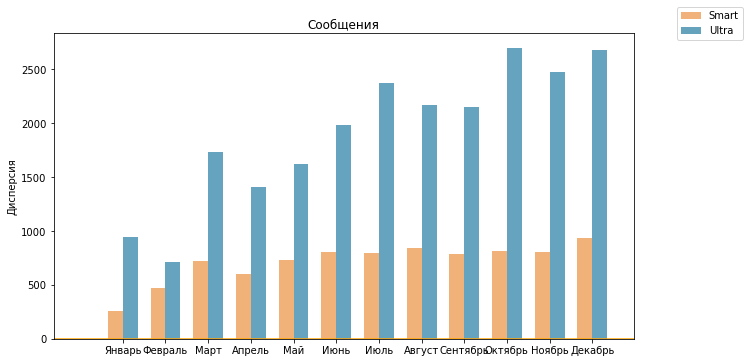

In [54]:
# график дисперсии смс для каждого тарифа в разрезе месяцев
bar_maker('new_var', 'messages_amount', 0, 'Сообщения', 'Дисперсия')

Дисперсия для тарифа Ultra принимает заметно более высокие значения — такое положение вещей можно было предсказать по графикам распределения: "хвост" в тарифе Ultra был более длинный.

Посмотрим на стандартное отклонение по каждой из услуг. В качестве константы установим первого квартиля для тарифа Smart (как следует из таблицы блока "Общая информация о поведении абонентов разных тарифов", значения для 25% отклонения по тарифам отличаются незначительно: звонки 282 Smart против 284 Ultra, интернет 12658 в Smart против 11785 в Ultra, сообщения 10 в Smart против 6 в Ultra; но поскольку на прошлых графиках в качестве порога использовали Smart, то сохраним эту логику). 

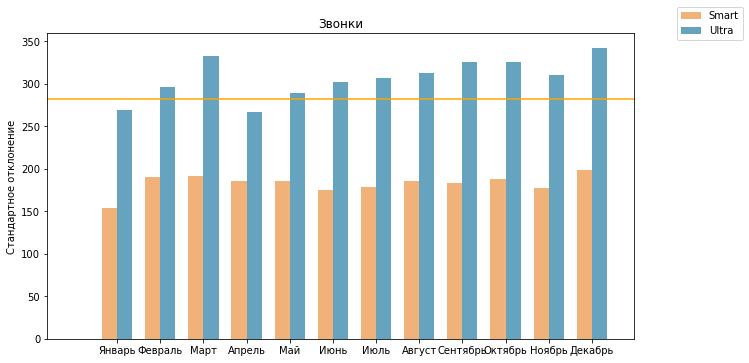

In [55]:
# график стандартного отклонения для использованных минут для каждого тарифа в разрезе месяцев
bar_maker('new_std', 'duration_up', 282, 'Звонки', 'Стандартное отклонение')

Величины стандартно отклонение тарифа Smart не превышают значение в 1 сигма. В тарифе Ultra по использованию минут отклонение почти всегда выше 1 сигма.

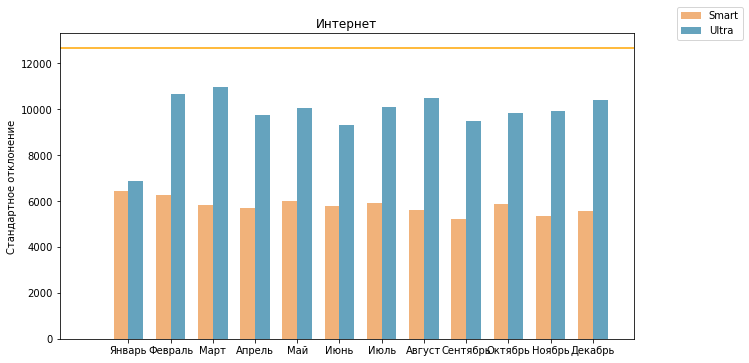

In [56]:
# график стандартного отклонения для использованных мегабайт для каждого тарифа в разрезе месяцев
bar_maker('new_std', 'mb_used_up', 12658, 'Интернет', 'Стандартное отклонение')

По услуге использование интернета по обоим тарифам отклонения не превышают значения в 1 сигма. Надо обратить внимание, что и сами интервали в этой характеристике большие — 25% граница проходит на уровне около 12000.

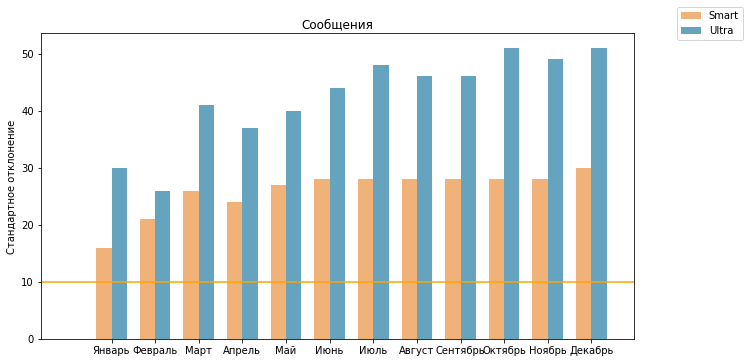

In [57]:
# график стандартного отклонения для использованных смс для каждого тарифа в разрезе месяцев
bar_maker('new_std', 'messages_amount', 10, 'Сообщения', 'Стандартное отклонение')

А вот отклоенения по пользованию SMS превышают 25% границу по обоим тарифам (тариф Smart не выходит и за границу в 50% или 28, на тарифе Ultra второй квартиль заканчивается значением 38, и в большинстве месяцев значения превышают этот порог).

Итак, разброс значений по тарифу Ultra больше по каждой характеристике. Стандартное отклонение укладывается в диапазон 1 сигма для интенета в обоих тарифах и для звонков в тарифе Smart. По SMS сообщениям отклонение превышает границу в 25% по обоим тарифам.

### Проверка гипотез

Цель исследования — определить, доходность по какому из тарифов выше. Поскольку данные по совокупной доходности тарифов недоступным, изучим, отличается ли средняя доходность на абонента по этим тарифам. 

Сформулируем нулевую гипотезу:
**H<sub>0</sub>** — средняя доходность абонента тарифа Smart равна средней доходности абонента тарифа Ultra.
Альтернативная гипотеза:
**H<sub>1</sub>** — средняя доходность абонента тарифа Smart не равна средней доходности абонента тарифа Ultra.

Создадим две таблицы, в которые выведем средний доход по пользователям каждого тарифа. Из датасета Smart выберем 148 случайных абонентов.

In [58]:
# создадим таблицу ultra_stat, куда отберем нужные столбцы и среднее значение дохода на абонента
ultra_stat = ultra_check.groupby(['user_id', 'city']).agg({'revenue': 'mean'}).astype(int).reset_index()

# создадим таблицу smart_stat_full с аналогичным содержанием
smart_stat_full = smart_check.groupby(['user_id', 'city']).agg({'revenue': 'mean'}).astype(int).reset_index()

# определим функцию для случайного выбора заданного количества записей из датасета
def cut(data, n):
    data2 = data.sample(n=n, random_state=1)
    return data2

# оставим в таблице по тарифу Smart 148 случайных записей, чтобы можно было сравнить с Ultra
smart_stat = cut(smart_stat_full, 148)

# проверим результат
smart_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148 entries, 192 to 332
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  148 non-null    int64 
 1   city     148 non-null    object
 2   revenue  148 non-null    int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 4.0+ KB


Для проверки нулевой гипотезы проведем t-test двух выборок. В данном случае ошибка второго рода более значима (ошибка первого рода — отвергнуть верную нулевую — это прийти к заключению, что средняя доходность на тарифах не равна, хотя она равна, что потребует дополнительных исследований, какой тариф более доходный; ошибка второго рода — принять неверную нулевую — заключить, что доходность на тарифах равна, хотя это не так; в этом случае заказчик, вероятно, откажется от продвижения либо сделает равное продвижение для обоих тарифов, что приведет к избыточным расходам). Поэтому выбран уровень значимости 5% (alpha = 0.05).

In [59]:
# напишем функцию для проверки гипотез
def ttest_2_data (alpha, data1, data2, equal_var):
    alpha = alpha
    results = st.ttest_ind(data1, data2, equal_var = equal_var)
    print('p-значение:', results.pvalue)
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу.')

In [60]:
# уровень значимости 5%, поскольку важно не совершить ошибку второго рода
# equal_var = False, поскольку стандартные отклонения в тарифах заметно отличаются
ttest_2_data(0.05, smart_stat['revenue'], ultra_stat['revenue'], False)

p-значение: 9.040978948222162e-30
Отвергаем нулевую гипотезу.


В результате проверки мы отвергли H<sub>0</sub> в пользу альтернативной гипотезы H<sub>1</sub>: средняя доходность абонента тарифа Smart не равна средней доходности абонента тарифа Ultra. Посмотрим, каков средний доход с абонента в выборке в разрезе тарифов.

In [61]:
print('Средняя доходность на тарифе Smart:', int(smart_stat_full['revenue'].mean()), 'р.')
print('Средняя доходность на тарифе Ultra:', int(ultra_stat['revenue'].mean()), 'р.')

Средняя доходность на тарифе Smart: 1329 р.
Средняя доходность на тарифе Ultra: 2087 р.


Средняя доходность на тарифе Ultra для абонентов, попавших в выборку, выше, чем для тарифа Smart (подобный результат уже был получен в разделе "Общая информация о поведении абонентов разных тарифов, разница в полученном среднем объясняется отсутствием группировки по месяцам). Проверим, является ли полученное среднее для выборки средним для генеральной совокупности. Опеределим нулевую и альтернативную гипотезу:

**H<sub>0</sub>** — средняя доходность выборки по тарифу равна средней доходности генеральной совокупности.
**H<sub>1</sub>** — средняя доходность выборки по тарифу не равна средней доходности генеральной совокупности.

Проведем t-test для выборок по каждому тарифу.

In [62]:
# напишем функицю для проведения теста
def ttest_1(a, alpha, data):
    revenue_mean = a
    alpha = alpha
    results = st.ttest_1samp(data, revenue_mean) 
    print('p-значение: ', results.pvalue)
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу.')

In [63]:
# проведем тест для тарифа Smart
ttest_1(1329, 0.01, smart_stat_full['revenue'])

p-значение:  0.9894658722995798
Не получилось отвергнуть нулевую гипотезу.


In [64]:
# проведем тест для тарифа Ultra
ttest_1(2087, 0.01, ultra_stat['revenue'])

p-значение:  0.9888982946790249
Не получилось отвергнуть нулевую гипотезу.


В результате в обоих тестах получили вероятность выше 98%, что наблюдаемое среднее близко к среднему генеральной совокупности. Следовательно, доходность тарифа Ultra выше. Посмотрим, есть ли разница в доходности между абонентами из столицы и жителями других городов. Нулевая и альтернативная гипотеза будут следующими:

**H<sub>0</sub>** — доходность абонентов из Москвы равна доходности абонентов из других городов.
**H<sub>1</sub>** — доходность абонентов из Москвы не равна доходности абонентов из других городов.

Проверим гипотезы для каждого тарифа в отдельности. Сначала подготовим таблицы для анализа и приведем их к равной длине.

In [65]:
# создадим таблицы с выборкой по МСК и по остальным городам
smart_stat_msk = smart_stat_full.query('city == "Москва"')
smart_stat_cities = smart_stat_full.query('city != "Москва"')

print('Количество абонентов Smart в Москве:', len(smart_stat_msk))
print('Количество абонентов Smart в других городах:', len(smart_stat_cities))

Количество абонентов Smart в Москве: 67
Количество абонентов Smart в других городах: 283


In [66]:
# создадим таблицы с выборкой по МСК и по остальным городам
ultra_stat_msk = ultra_stat.query('city == "Москва"')
ultra_stat_cities = ultra_stat.query('city != "Москва"')

print('Количество абонентов Ultra в Москве:', len(ultra_stat_msk))
print('Количество абонентов Ultra в других городах:', len(ultra_stat_cities))

Количество абонентов Ultra в Москве: 32
Количество абонентов Ultra в других городах: 116


In [67]:
# оставим в таблице по другим городам 67 случайных записей, чтобы можно было сравнить с Москвой
smart_stat_cities_cut = cut(smart_stat_cities, 67)

In [68]:
# оставим в таблице по другим городам 32 случайных записb, чтобы можно было сравнить с Москвой
ultra_stat_cities_cut = cut(ultra_stat_cities, 32)

Проверим ранее озвученную гипотезу: доходность абонентов из Москвы равна доходности абонентов из других городов.

In [69]:
ttest_2_data(0.05, smart_stat_msk['revenue'], smart_stat_cities_cut['revenue'], True)

p-значение: 0.9846581329458434
Не получилось отвергнуть нулевую гипотезу.


In [70]:
ttest_2_data(0.05, ultra_stat_msk['revenue'], ultra_stat_cities_cut['revenue'], True)

p-значение: 0.17731920187606956
Не получилось отвергнуть нулевую гипотезу.


Итак, между абонентами из Москвы и абонентами из других городов нет значимоый статистической разницы ни в одном из тарифов. В среднем, доходность в Москве и регионах сходная, при этом на тарифе Ultra доходность выше.

## Общие выводы

Средняя доходность тарифов Smart и Ultra различается. Средний доход абонентов в выборке по тарифу Ultra составляет 2087 р., по тарифу Smart — 1329 р. Средние значения выборки близки к средним значеним генеральной совокупности, соответственно, тариф Ultra является более доходным в расчете на абонента. Не выявлено значимой разницы между абонентами из Москвы и других городов.

**Расширенные выводы по результатам проекта:**
- Не все абоненты пользуются всеми способами связи, заложенными в тариф: интернетом не пользовались 3 абонента из 500, звонками 8 абонентов, SMS не использовали 74 абонента.
- В выборке 2/3 — пользователи тарифа Smart, 1/3 — Ultra.
- В тарифе Ultra распределения использования услуг более равномерное. В тарифе Smart есть ярко выраженное "ядро".
- Абоненты тарифа Ultra в среднем пользуются бОльшим количеством минут, мегабайт и смс. Но разница не столь существенная — в тарифный лимит у Ultra включено в 6 раз больше минут, в 2 раза больше трафика и в 20 раз больше SMS. По факту, пользователи Ultra в среднем лишь незначительно превышают лимиты, установленные для тарифа Smart. 
- По обоим тарифам по всем видам услуг наблюдается заметный спад в январе-феврале.